# **Solubility dataset**

### **Load data**

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/dataprofessor/data/master/delaney_solubility_with_descriptors.csv')
df

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


### **Data pre-processing**

**Separate X and y from df**

In [ ]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

**Data splitting**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [ ]:
X_train, X_test, y_train, y_test

(array([[2.41960000e+00, 2.46306000e+02, 0.00000000e+00, 0.00000000e+00],
        [1.65930000e+00, 1.16204000e+02, 2.00000000e+00, 0.00000000e+00],
        [2.41380000e+00, 1.06596000e+02, 1.00000000e+00, 0.00000000e+00],
        ...,
        [2.71412000e+00, 3.65842000e+02, 2.00000000e+00, 5.00000000e-01],
        [6.49018000e+00, 5.05206000e+02, 6.00000000e+00, 4.28571429e-01],
        [1.78010000e+00, 1.64208000e+02, 1.00000000e+00, 5.00000000e-01]]),
 array([[ 5.76050000e+00,  3.50458000e+02,  6.00000000e+00,
          4.61538462e-01],
        [ 4.66040000e+00,  2.23102000e+02,  1.00000000e+00,
          8.57142857e-01],
        [ 2.51990000e+00,  1.58241000e+02,  6.00000000e+00,
          0.00000000e+00],
        [-2.21310000e+00,  2.54246000e+02,  3.00000000e+00,
          5.00000000e-01],
        [ 7.27400000e+00,  3.60882000e+02,  1.00000000e+00,
          6.66666667e-01],
        [ 3.17972000e+00,  2.96374000e+02,  2.00000000e+00,
          5.45454545e-01],
        [ 4.3002000

**Feature scaling**

We're going to scale the features via standardization.

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [ ]:
pd.DataFrame(X_train_std).describe()

,0,1,2,3
count,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02
mean,2.377455e-15,1.730613e-15,1.522765e-17,4.240081e-16
std,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00
min,-5.313555e+00,-1.830272e+00,-8.132109e-01,-1.067154e+00
25%,-5.454843e-01,-8.112420e-01,-8.132109e-01,-1.067154e+00
50%,-6.509291e-02,-2.188806e-01,-4.302526e-01,1.940546e-02
75%,4.987897e-01,7.071100e-01,3.356640e-01,8.645075e-01
max,4.199250e+00,5.584845e+00,7.994830e+00,1.830338e+00


### **Sequential feature selection algorithm**

Creating the SBS feature selection algorithm developed by Raschka et al. (2022).

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### **Build a random forest model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=1)

 1) MolLogP                        0.831375
 2) MolWt                          0.126328
 3) AromaticProportion             0.023305
 4) NumRotatableBonds              0.018991


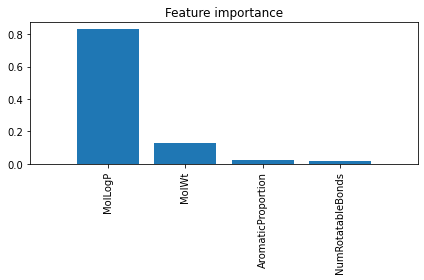

In [ ]:
feat_labels = df.columns[:-1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()